# Data

In [186]:
TRAIN_FLAG = True

In [187]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=5):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()

In [188]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput


class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [189]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [190]:
from utils.data import sample_indices

train_indeces = sample_indices(mnist_trainset.targets, k=120, seed=42)

remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=20, seed=42)

In [191]:
train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.
print(train_dataset.shape, eval_dataset.shape)

torch.Size([1200, 1, 28, 28]) torch.Size([200, 1, 28, 28])


In [192]:
# train_dataset = MNIST(train_dataset)
# eval_dataset = MNIST(eval_dataset)

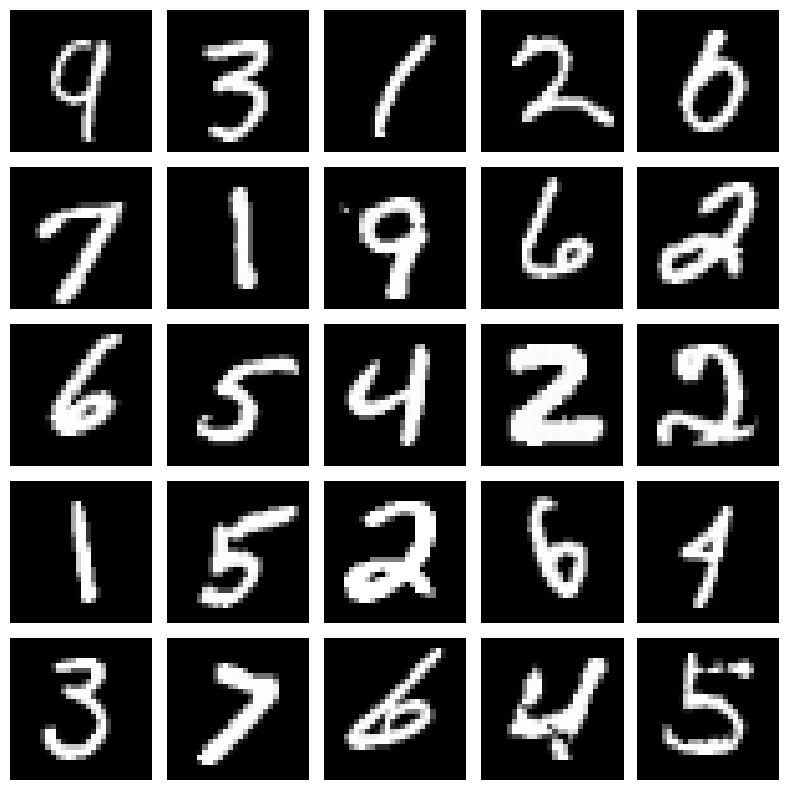

In [193]:
plot_grid(train_dataset.data)

# TRAIN

## Configure Training

In [194]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }


model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-2
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=8,
# )

# model = VAE(
#     model_config=model_config,
#     encoder=Encoder_ResNet_VAE_MNIST(model_config),
#     decoder=Decoder_ResNet_AE_MNIST(model_config)
# )

In [195]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 194 µs, sys: 7 µs, total: 201 µs
Wall time: 208 µs


946391

In [196]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Early Stopping

In [209]:
from pytorch_lightning.callbacks import EarlyStopping
# early_stop_cb = EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-5,
#     patience=3,
#     verbose=False,
#     mode='min')

from pythae.trainers.training_callbacks import *

class EarlyStopping(TrainingCallback):
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_metric = np.Inf if mode == 'min' else -np.Inf
        self.counter = 0
        self.early_stop = False

    def on_eval_step_end(self, training_config: BaseTrainerConfig, **kwargs):
        logger = kwargs.pop("logger", self.logger)

        if logger is not None:
            current_metric = logger.get("eval_epoch_loss", None)

            if self.mode == 'min':
                improvement = current_metric < self.best_metric - self.min_delta
            else:
                improvement = current_metric > self.best_metric + self.min_delta

            if improvement:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

            return self.early_stop

early_stop_cb = EarlyStopping(
    min_delta=10,
    patience=0,
    mode='min')

callbacks = []
callbacks.append(early_stop_cb)

## Train

In [198]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=50,
    learning_rate=5e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_params={'weight_decay':1e-4},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)


if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-04-15_17-03-11. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 50
 - per_device_train_batch_size: 1200
 - per_device_eval_batch_size: 200
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x76f9b6ce35b0>

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 19050094.0
Eval loss: 60.7119
--------------------------------------------------------------------------


Training of epoch 2/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.8769
Eval loss: 42.6916
--------------------------------------------------------------------------


Training of epoch 3/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43274813440.0
Eval loss: 38.0145
--------------------------------------------------------------------------


Training of epoch 4/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.8467
Eval loss: 37.4626
--------------------------------------------------------------------------


Training of epoch 5/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 784.7289
Eval loss: 34.4562
--------------------------------------------------------------------------


Training of epoch 6/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1696605798400.0
Eval loss: 34.6546
--------------------------------------------------------------------------


Training of epoch 7/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9128385.0
Eval loss: 35.7673
--------------------------------------------------------------------------


Training of epoch 8/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.9917
Eval loss: 37.1519
--------------------------------------------------------------------------


Training of epoch 9/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.5489
Eval loss: 38.7208
--------------------------------------------------------------------------


Training of epoch 10/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.493
Eval loss: 40.2609
--------------------------------------------------------------------------


Training of epoch 11/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7971
Eval loss: 41.7467
--------------------------------------------------------------------------


Epoch 00011: reducing learning rate of group 0 to 2.5000e-03.


Training of epoch 12/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.5483
Eval loss: 42.1518
--------------------------------------------------------------------------


Training of epoch 13/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.5143
Eval loss: 42.4561
--------------------------------------------------------------------------


Training of epoch 14/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3773
Eval loss: 42.998
--------------------------------------------------------------------------


Training of epoch 15/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.9085
Eval loss: 43.3209
--------------------------------------------------------------------------


Training of epoch 16/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.4644
Eval loss: 44.0266
--------------------------------------------------------------------------


Training of epoch 17/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.1984
Eval loss: 44.2382
--------------------------------------------------------------------------


Epoch 00017: reducing learning rate of group 0 to 1.2500e-03.


Training of epoch 18/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.2245
Eval loss: 44.2004
--------------------------------------------------------------------------


Training of epoch 19/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.7498
Eval loss: 44.4323
--------------------------------------------------------------------------


Training of epoch 20/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.033
Eval loss: 44.3922
--------------------------------------------------------------------------


Training of epoch 21/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.547
Eval loss: 44.4013
--------------------------------------------------------------------------


Training of epoch 22/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.0974
Eval loss: 44.6316
--------------------------------------------------------------------------


Training of epoch 23/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.8066
Eval loss: 44.9719
--------------------------------------------------------------------------


Epoch 00023: reducing learning rate of group 0 to 6.2500e-04.


Training of epoch 24/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.1838
Eval loss: 44.8912
--------------------------------------------------------------------------


Training of epoch 25/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.0337
Eval loss: 44.8283
--------------------------------------------------------------------------


Training of epoch 26/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.9301
Eval loss: 44.9835
--------------------------------------------------------------------------


Training of epoch 27/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.9992
Eval loss: 44.9385
--------------------------------------------------------------------------


Training of epoch 28/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.6038
Eval loss: 44.8872
--------------------------------------------------------------------------


Training of epoch 29/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.1494
Eval loss: 44.7427
--------------------------------------------------------------------------


Epoch 00029: reducing learning rate of group 0 to 3.1250e-04.


Training of epoch 30/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.5673
Eval loss: 44.6712
--------------------------------------------------------------------------


Training of epoch 31/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.8734
Eval loss: 44.7664
--------------------------------------------------------------------------


Training of epoch 32/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.463
Eval loss: 44.6614
--------------------------------------------------------------------------


Training of epoch 33/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.0544
Eval loss: 44.7848
--------------------------------------------------------------------------


Training of epoch 34/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.22
Eval loss: 44.8655
--------------------------------------------------------------------------


Training of epoch 35/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3195
Eval loss: 44.8564
--------------------------------------------------------------------------


Epoch 00035: reducing learning rate of group 0 to 1.5625e-04.


Training of epoch 36/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.4905
Eval loss: 44.9221
--------------------------------------------------------------------------


Training of epoch 37/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.2883
Eval loss: 44.734
--------------------------------------------------------------------------


Training of epoch 38/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1887
Eval loss: 44.6706
--------------------------------------------------------------------------


Training of epoch 39/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.5027
Eval loss: 44.8562
--------------------------------------------------------------------------


Training of epoch 40/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1101
Eval loss: 44.7359
--------------------------------------------------------------------------


Training of epoch 41/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0893
Eval loss: 44.5469
--------------------------------------------------------------------------


Epoch 00041: reducing learning rate of group 0 to 7.8125e-05.


Training of epoch 42/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.9607
Eval loss: 44.9342
--------------------------------------------------------------------------


Training of epoch 43/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1926
Eval loss: 44.63
--------------------------------------------------------------------------


Training of epoch 44/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.993
Eval loss: 44.7721
--------------------------------------------------------------------------


Training of epoch 45/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0056
Eval loss: 44.636
--------------------------------------------------------------------------


Training of epoch 46/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0106
Eval loss: 44.7682
--------------------------------------------------------------------------


Training of epoch 47/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.3153
Eval loss: 44.5445
--------------------------------------------------------------------------


Epoch 00047: reducing learning rate of group 0 to 3.9063e-05.


Training of epoch 48/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0407
Eval loss: 44.4927
--------------------------------------------------------------------------


Training of epoch 49/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.6115
Eval loss: 44.5815
--------------------------------------------------------------------------


Training of epoch 50/50:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.2722
Eval loss: 44.7694
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-04-15_17-03-11/final_model


# GEMERATE

In [199]:
from pythae.models import AutoModel

import glob

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(
        glob.glob('experiments/*/final_model')[0]
    )

### Normal Sampler

In [200]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

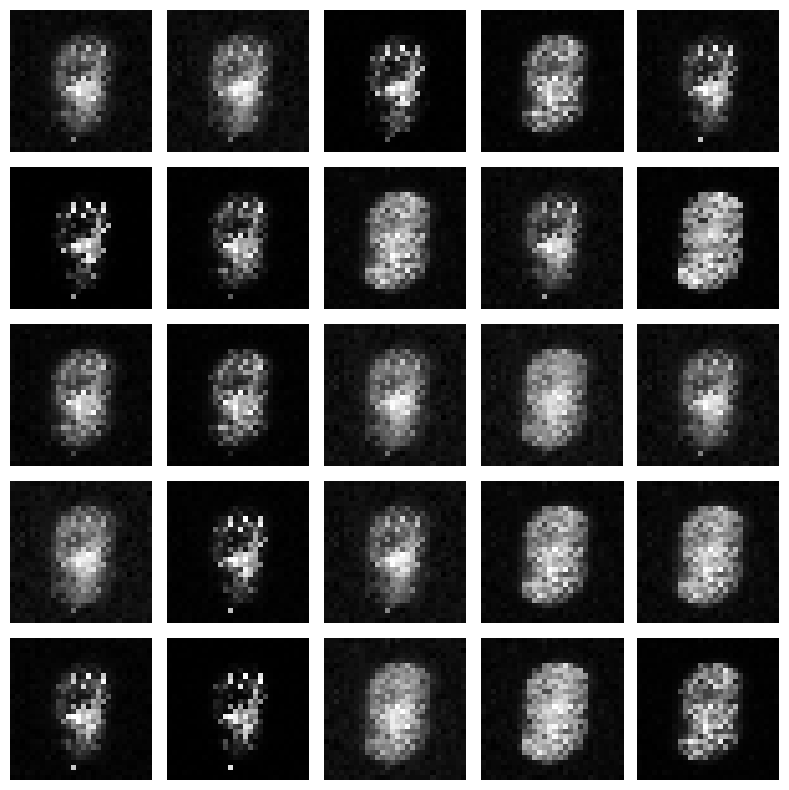

In [201]:
plot_grid(gen_data.data)

### Gaussian Mixture Model Sampler

In [202]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

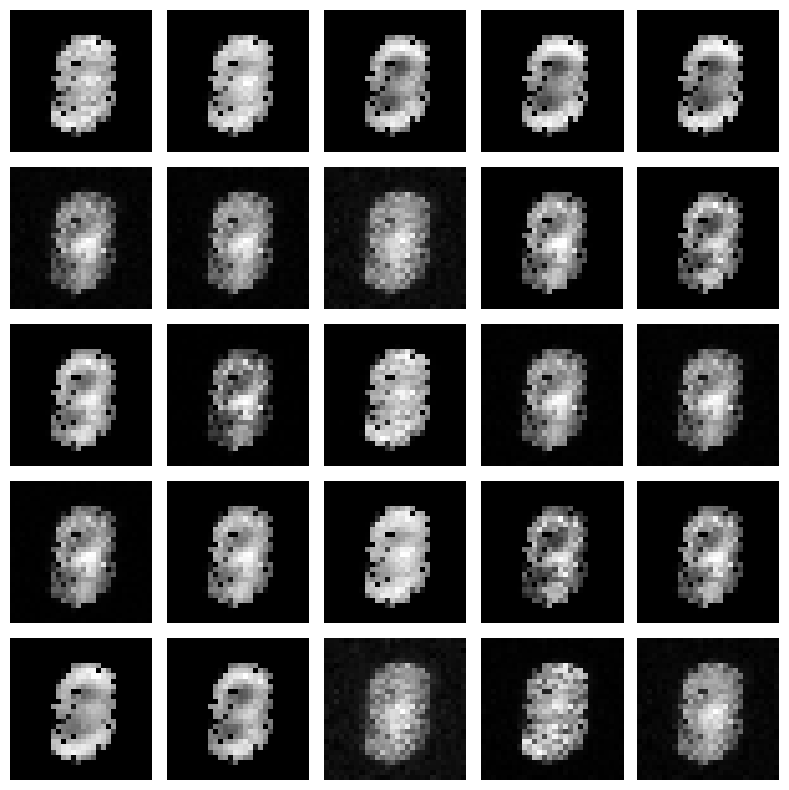

In [203]:
plot_grid(gmm_gen_data.data)

### RHVAE Sampler

In [204]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

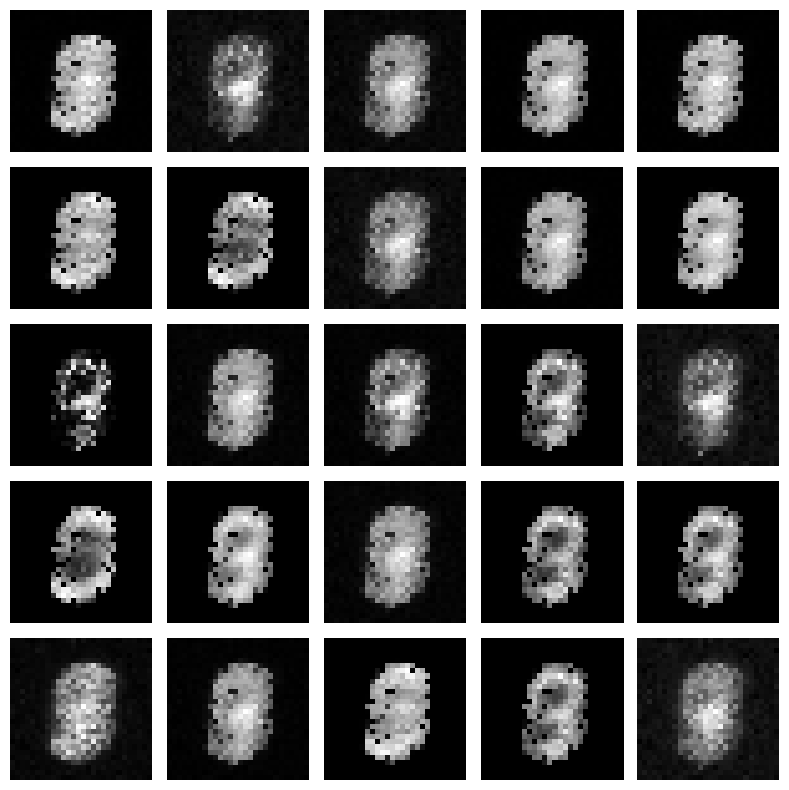

In [205]:
plot_grid(rh_gen_data)

In [206]:
rh_gen_data.shape

torch.Size([25, 1, 28, 28])

In [207]:
#combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
combined_dataset.shape

torch.Size([1225, 1, 28, 28])